<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="#Locally-defined-functions" data-toc-modified-id="Locally-defined-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Locally defined functions</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Read-Automotive-stocks-data" data-toc-modified-id="Read-Automotive-stocks-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Read Automotive stocks data</a></span></li><li><span><a href="#Portfolios-of-automotive-stocks-with-random-weights" data-toc-modified-id="Portfolios-of-automotive-stocks-with-random-weights-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Portfolios of automotive stocks with random weights</a></span></li></ul></li><li><span><a href="#Portfolio-optimization" data-toc-modified-id="Portfolio-optimization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Portfolio optimization</a></span><ul class="toc-item"><li><span><a href="#Maximize-Sharpe-ratio" data-toc-modified-id="Maximize-Sharpe-ratio-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Maximize Sharpe ratio</a></span></li><li><span><a href="#Minimize-variance" data-toc-modified-id="Minimize-variance-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Minimize variance</a></span></li><li><span><a href="#Minimize-volatility-for-given-returns" data-toc-modified-id="Minimize-volatility-for-given-returns-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Minimize volatility for given returns</a></span></li><li><span><a href="#Plot-efficient-frontier-and-optimized-portfolios" data-toc-modified-id="Plot-efficient-frontier-and-optimized-portfolios-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Plot efficient frontier and optimized portfolios</a></span></li><li><span><a href="#Tangency-portfolio-and-capital-market-line" data-toc-modified-id="Tangency-portfolio-and-capital-market-line-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Tangency portfolio and capital market line</a></span></li></ul></li><li><span><a href="#Indices" data-toc-modified-id="Indices-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Indices</a></span><ul class="toc-item"><li><span><a href="#Select-data-range-and-prepare-dataframes" data-toc-modified-id="Select-data-range-and-prepare-dataframes-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Select data range and prepare dataframes</a></span></li><li><span><a href="#Insights-for-indices" data-toc-modified-id="Insights-for-indices-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Insights for indices</a></span></li></ul></li><li><span><a href="#Market-regression" data-toc-modified-id="Market-regression-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Market regression</a></span></li></ul></div>

Sources:


https://blog.quantopian.com/markowitz-portfolio-optimization-2/

http://cvxopt.org/examples/book/portfolio.html

https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

http://www.pythonforfinance.net/2017/01/21/investment-portfolio-optimisation-with-python/

http://dacatay.com/data-science/portfolio-optimization-python/


Quantopian tutorials

https://www.quantopian.com/tutorials/getting-started



# Load libraries

In [2]:
# libraries

# general
import sys
import os


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

import datetime

import scipy.stats

import scipy.optimize as sco
import scipy.interpolate as sci

from sklearn import linear_model

np.random.seed(1234)

# Turn off progress printing 
#solvers.options['show_progress'] = False

#import pandas_datareader.data as web


# # add the base path to python system path
path = os.getcwd()
#dir_up = os.path.abspath(os.path.join(path, os.pardir))
base_path = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(base_path)

# # libraries within package
from src.finance_functions import multiple_returns_from_levels_vec 
from src.finance_functions import df_restrict_dates

# Locally defined functions

In [3]:
# functions

# assume index is date
def df_restrict_dates(df_in, start_date, end_date):
    df_out = df_in.copy()
    mask = (df_out.index >= start_date) & (df_out.index <= end_date)
    return df_out[mask]

def add_returns(df_in, col_name='Close', method='diff', period=1, new_col_name=None):
    assert method in ['diff','log'], ' not implemented'
    if new_col_name is None:
        if method == 'diff':
            new_col_name = 'returns'
        elif method == 'log':
            new_col_name = 'log_returns'
    df = df_in.copy()
    if method =='diff':
        df[new_col_name] = (df[col_name] - df[col_name].shift(period))/df[col_name].shift(period)
    elif method == 'log':
        df[new_col_name] = np.log(df[col_name]/df[col_name].shift(period))
        
    df[new_col_name] = df[new_col_name].bfill()
    return df


In [4]:
def statistics(weights):
    ''' Return portfolio statistics.
    auto_stocks_returns is a global variable here, that is not very nice
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    # returns scaled up to one year (252 trading days)
    pret = np.sum(auto_stocks_returns.mean(axis=0) * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(auto_stocks_returns.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

# function to minimize: portfolio standard deviation/volatility
def min_func_port(weights):
    return statistics(weights)[1]

# function to maximize Sharpe ratio for for rf=0
def min_func_sharpe(weights):
    return -statistics(weights)[2]

# function to minimize portfolio variance
def min_func_variance(weights):
    return statistics(weights)[1] ** 2


def portfolio_distribution(weights, constituents):
    return dict(zip(constituents,weights))

def efficient_frontier_f(x, der=0):
    ''' Efficient frontier function (splines approximation) and derivative '''
    return sci.splev(x, tck, der=der)

# equations for capital market line for given risk free rate
# general: r = p0 + p1 * sigma
# eq1: r(0) = rf : p0 = rf
# eq2: p0 + p1 * p2 =  f(p2) # intersection point
# eq3: p1 = d f /d s (p2)  # slope the same as efficient frontier for tangential portfolio

def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = p[0] + p[1] * p[2] - efficient_frontier_f(p[2])
    eq3 = p[1] - efficient_frontier_f(p[2],der=1)
    return eq1, eq2, eq3


In [5]:
def correlation_map(df,figsize=(16,10),font_scale = 1.5):        
    
    features = list(df.columns)
    cm = df.corr(method='spearman')
    sns.set(font_scale=font_scale)

    fig, ax = plt.subplots(figsize=figsize)

    hm = sns.heatmap(cm,
                     ax=ax,
                     cbar=False,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 15},
                     yticklabels=features,
                     xticklabels=features) 
    plt.show() 
        
    return plt

# Load data 

## Read Automotive stocks data

In [6]:
filename = '../data/data_sample_daily.csv'
infile = filename
df_comb_long = pd.read_csv(infile)
df_comb_long['date'] = pd.to_datetime(df_comb_long['date'])

In [7]:
df_comb_long.head()

,date,company,Country,Price_USD,Shares,MktCapUSD
0,2008-01-02,FORD MTR CO,USA,6.60,2039353000,1.345973e+10
1,2008-01-03,FORD MTR CO,USA,6.45,2039353000,1.315383e+10
2,2008-01-04,FORD MTR CO,USA,6.13,2039353000,1.250123e+10
3,2008-01-07,FORD MTR CO,USA,6.16,2039353000,1.256241e+10
4,2008-01-08,FORD MTR CO,USA,6.10,2039353000,1.244005e+10


In [8]:
#eq_name = 'Equity Parent'
eq_name = 'company'
df_prices = df_comb_long.pivot(values='Price_USD', index='date', columns=eq_name)

# PUT VECTORIZED VERSION
# monthly returns
#df_returns = multiple_returns_from_levels(df_prices.ffill(), frequency='monthly')
df_returns = multiple_returns_from_levels_vec(df_prices.ffill())

In [9]:
l_companies = list(df_returns.columns)

In [10]:
# only take first 5 companies
auto_stocks_returns = df_returns[l_companies[:8]].copy()

In [55]:
# dates for backtesting period
start_date = datetime.datetime(2010, 5, 1)
end_date = datetime.datetime(2016, 4, 1)

In [56]:
# auto_stocks_returns = df_restrict_dates(auto_stocks_returns, start_date, end_date)

In [57]:
auto_stocks_returns.head()

company,BAYER MOTOREN WERK,BYD COMPANY LTD,DAIMLER AG,FIAT CHRYSLER AUTO,FORD MTR CO,GEELY AUTOMOBILE H,GENERAL MTRS CO COM,HONDA MOTOR CO
date,,,,,,,,
2010-05-03,-0.002472,0.005090,-0.014249,-0.003168,0.021505,-0.005789,NaN,0.000000
2010-05-04,-0.051533,0.016735,-0.042672,-0.076002,-0.033835,-0.021016,NaN,0.000000
2010-05-05,-0.009035,-0.038426,-0.022136,-0.043507,-0.039689,-0.021566,NaN,0.000000
2010-05-06,-0.000006,-0.017955,-0.014489,-0.030624,-0.045381,0.005544,NaN,-0.025820
2010-05-07,-0.030333,-0.025315,-0.033751,-0.056146,-0.022920,0.017367,NaN,-0.000838


In [12]:
#auto_stocks_returns.plot(figsize=(12,10))
auto_stocks_returns.corr()

company,BAYER MOTOREN WERK,BYD COMPANY LTD,DAIMLER AG,FIAT CHRYSLER AUTO,FORD MTR CO,GEELY AUTOMOBILE H,GENERAL MTRS CO COM,HONDA MOTOR CO
company,,,,,,,,
BAYER MOTOREN WERK,1.000000,0.169651,0.849449,0.688053,0.324890,0.212600,0.407368,0.178329
BYD COMPANY LTD,0.169651,1.000000,0.170356,0.151203,0.058173,0.347062,0.087291,0.183079
DAIMLER AG,0.849449,0.170356,1.000000,0.711994,0.341495,0.197474,0.407488,0.184245
FIAT CHRYSLER AUTO,0.688053,0.151203,0.711994,1.000000,0.317410,0.148276,0.369738,0.134368
FORD MTR CO,0.324890,0.058173,0.341495,0.317410,1.000000,0.084589,0.708779,0.061101
GEELY AUTOMOBILE H,0.212600,0.347062,0.197474,0.148276,0.084589,1.000000,0.124236,0.200613
GENERAL MTRS CO COM,0.407368,0.087291,0.407488,0.369738,0.708779,0.124236,1.000000,0.085917
HONDA MOTOR CO,0.178329,0.183079,0.184245,0.134368,0.061101,0.200613,0.085917,1.000000


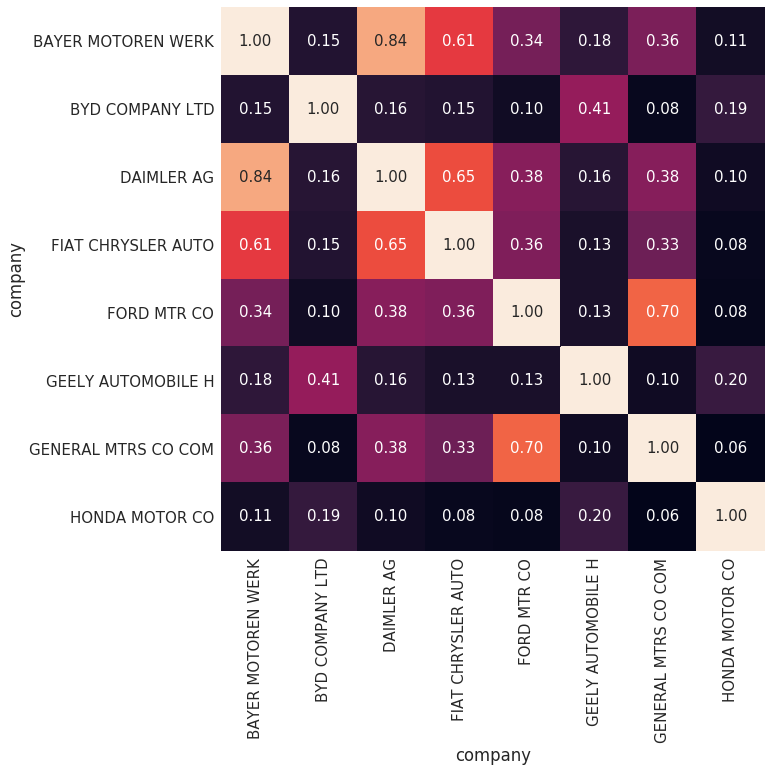

In [58]:
cpl = correlation_map(auto_stocks_returns)

## Portfolios of automotive stocks with random weights

In [ ]:
noa = len(auto_stocks_returns.columns)

In [14]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights
dict(zip(auto_stocks_returns.columns,weights))

{'BAYER MOTOREN WERK': 0.04595416050428265,
 'BYD COMPANY LTD': 0.14927197346759538,
 'DAIMLER AG': 0.10503064172184279,
 'FIAT CHRYSLER AUTO': 0.18844297191746878,
 'FORD MTR CO': 0.1871514010970627,
 'GEELY AUTOMOBILE H': 0.06540726965672035,
 'GENERAL MTRS CO COM': 0.06633625320774741,
 'HONDA MOTOR CO': 0.19240532842727992}

In [15]:
np.sum(auto_stocks_returns.mean() * weights) * 252
# expected portfolio return (for chosen weights) in one year

0.1638122828548633

In [16]:
np.dot(weights.T, np.dot(auto_stocks_returns.cov() * 252, weights))
# expected portfolio variance (volatility)

0.07314309500708968

In [17]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(auto_stocks_returns.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(auto_stocks_returns.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


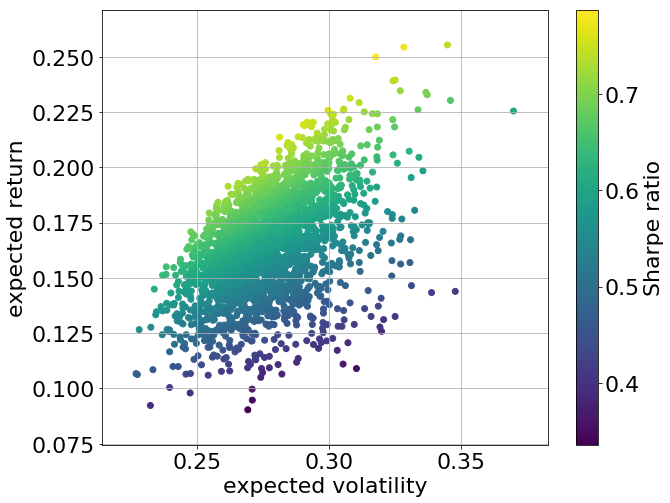

In [18]:
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

plt.figure(figsize=(10, 8))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')



# tag: portfolio_2
# title: Expected return and volatility for different/random portfolio weights
# size: 90

# Portfolio optimization

## Maximize Sharpe ratio

In [19]:
%%time



cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
# homogeneous initial values
starting_values = noa * [1. / noa,]

opts = sco.minimize(min_func_sharpe, starting_values, method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 395 ms, sys: 3.74 ms, total: 399 ms
Wall time: 486 ms


In [64]:
#opts
#opts.x
# optimized weights for constituents
#pd.DataFrame(portfolio_distribution(map(lambda x: round(x,3),opts['x']), auto_stocks_returns.columns), index=[1])
portfolio_distribution(map(lambda x: round(x,3),opts['x']), auto_stocks_returns.columns)

{'BAYER MOTOREN WERK': 0.083,
 'BYD COMPANY LTD': 0.234,
 'DAIMLER AG': 0.0,
 'FIAT CHRYSLER AUTO': 0.024,
 'FORD MTR CO': 0.295,
 'GEELY AUTOMOBILE H': 0.363,
 'GENERAL MTRS CO COM': 0.0,
 'HONDA MOTOR CO': 0.0}

## Minimize variance

In [21]:
%%time


cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
# homogeneous initial values
starting_values = noa * [1. / noa,]

optv = sco.minimize(min_func_variance, starting_values, method='SLSQP', bounds=bnds, constraints=cons)
#optv = sco.minimize(min_func_port, starting_values, method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 644 ms, sys: 3.83 ms, total: 648 ms
Wall time: 667 ms


In [22]:
#optv

## Minimize volatility for given returns

In [23]:
%%time

# Minimize a scalar function of one or more variables using Sequential Least SQuares Programming (SLSQP).
# Constraints
# 1 porfolio return equal to predefined one (tret)
# 2 sum of weights = 1
# cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
#        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

# homogeneous initial values
starting_values = noa * [1. / noa,]


#trets = np.linspace(0.0, 0.4, 50)
#trets = np.linspace(0.06, 0.4, 50)
trets = np.linspace(0.06, 0.32, 40)
tvols = []
# run optimization for fixed values of the returns
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, starting_values, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 22.3 s, sys: 137 ms, total: 22.4 s
Wall time: 22.6 s


In [24]:
#res

In [25]:
# return variance and weights for the "last portfolio in the loop
print(tret)
print(res['fun'])
portfolio_distribution(res['x'].round(3), auto_stocks_returns.columns)

0.32
0.47240991308172037


{'BAYER MOTOREN WERK': 0.0,
 'BYD COMPANY LTD': 0.211,
 'DAIMLER AG': 0.0,
 'FIAT CHRYSLER AUTO': 0.0,
 'FORD MTR CO': 0.0,
 'GEELY AUTOMOBILE H': 0.789,
 'GENERAL MTRS CO COM': 0.0,
 'HONDA MOTOR CO': 0.0}

## Plot efficient frontier and optimized portfolios

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


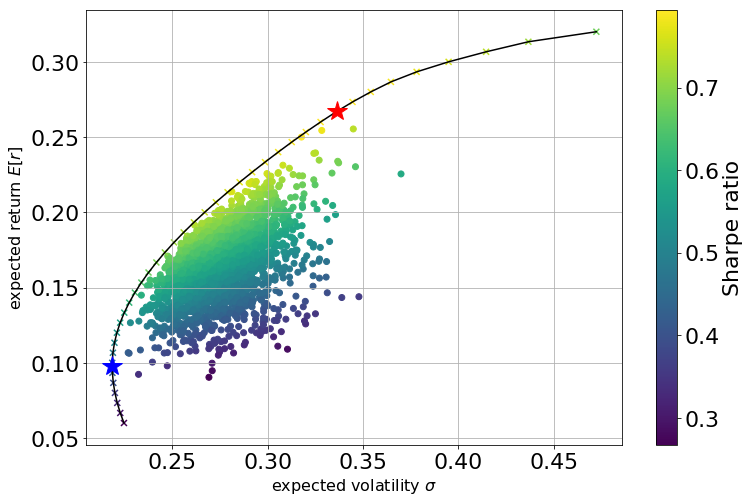

In [26]:
plt.figure(figsize=(12, 8))

# plot random portfolios as dots
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
            
# volatility minimized portfolios (efficient frontier)
plt.scatter(tvols, trets, c=trets / tvols, marker='x')
plt.plot(tvols, trets, 'k-')
            
# portfolio with highest Sharpe ratio
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=20.0)
            
# minimum variance portfolio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'b*', markersize=20.0)
            
plt.grid(True)
plt.xlabel('expected volatility $\sigma$',fontsize=16)
plt.ylabel('expected return $E[r]$', fontsize=16)
plt.colorbar(label='Sharpe ratio')
# tag: portfolio_3
# title: Minimum risk portfolios for given return level (crosses)
# size: 90

In [27]:
# return variance and weights for optimized portfolios
#portfolio_distribution(opts['x'].round(3), auto_stocks_returns.columns)
portfolio_distribution(map(lambda x: round(x,2),optv['x']), auto_stocks_returns.columns)

{'BAYER MOTOREN WERK': 0.11,
 'BYD COMPANY LTD': 0.05,
 'DAIMLER AG': 0.0,
 'FIAT CHRYSLER AUTO': 0.0,
 'FORD MTR CO': 0.05,
 'GEELY AUTOMOBILE H': 0.07,
 'GENERAL MTRS CO COM': 0.43,
 'HONDA MOTOR CO': 0.29}

## Tangency portfolio and capital market line

In [28]:
# monotonous part of points in the efficient frontier
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]
# spline representation
tck = sci.splrep(evols, erets)

In [29]:
# find parameters p0, p1 for the capital market line
# p0: intercepts
# p1: slope
# p2: sigma for intersection

# risk free rate
rf = 0.01

p_ini = [rf, 0.5, 0.3]

opt = sco.fsolve(equations, p_ini)
intercept = opt[0]
slope = opt[1]
vol_tang = opt[2]


In [30]:
equations(opt)
#opt

(0.0, -1.2212453270876722e-15, 8.548717289613705e-15)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


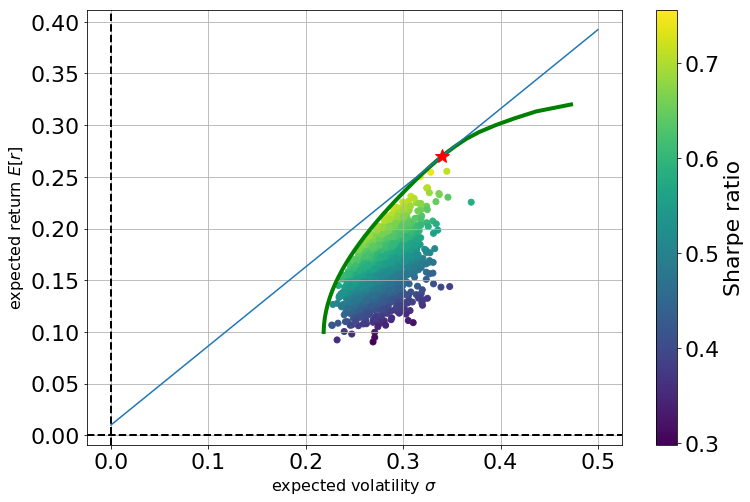

In [31]:
plt.figure(figsize=(12, 8))
# random portfolio composition
plt.scatter(pvols, prets, c=(prets - rf) / pvols, marker='o')

# positive part of efficient frontier
plt.plot(evols, erets, 'g', lw=4.0)
            
cx = np.linspace(0.0, 0.5)

# capital market line
plt.plot(cx, intercept + slope * cx, lw=1.5)
            
# point of the tangential portfolio
plt.plot(opt[2], efficient_frontier_f(vol_tang), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility $\sigma$',fontsize=16)
plt.ylabel('expected return $E[r]$', fontsize=16)
plt.colorbar(label='Sharpe ratio')
# tag: portfolio_4
# title: Capital market line and tangency portfolio (star) for risk-free rate of 1%
# size: 90

In [32]:
# find tangency portfolio 
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - efficient_frontier_f(vol_tang)},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
starting_values = noa * [1. / noa,]
res_tang = sco.minimize(min_func_port, starting_values, method='SLSQP', bounds=bnds, constraints=cons)

In [33]:

# Sharpe ratio tangential portfolio is equal to the slope of the capital market line
print("slope",slope)
print("Sharpe ratio",(efficient_frontier_f(vol_tang)-rf)/vol_tang)
portfolio_distribution(res_tang['x'].round(3),auto_stocks_returns.columns)

slope 0.7646839341168233
Sharpe ratio 0.7646839341168269


{'BAYER MOTOREN WERK': 0.067,
 'BYD COMPANY LTD': 0.24,
 'DAIMLER AG': 0.0,
 'FIAT CHRYSLER AUTO': 0.024,
 'FORD MTR CO': 0.297,
 'GEELY AUTOMOBILE H': 0.371,
 'GENERAL MTRS CO COM': 0.0,
 'HONDA MOTOR CO': 0.0}

In [34]:
slope

0.7646839341168233

In [35]:
#auto_stocks_returns.head()

# Indices

In [36]:
# indices
l_indices = [
    'dax',
    'dow_jones',
    'nikkei_225',
    's_and_p_index'
]

In [37]:
# read auto stock quotes and indices

DATA_PATH = '../data/'

d_indices = {}

read_from_file = True
if read_from_file:
    for ind in l_indices:
        print(ind)
        filename = '%s.csv' % ind
        #infile = DATA_PATH + 'indices/' + filename
        infile = DATA_PATH + filename
        df = pd.read_csv(infile)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date',drop=True, inplace=True)
        for col in df.columns:
            df[col] = df[col].astype('float')
        d_indices[ind] = df

dax
dow_jones
nikkei_225
s_and_p_index


## Select data range and prepare dataframes

In [38]:
start_date = datetime.datetime(2000,1,1)
end_date = datetime.datetime(2017,7,1)

In [39]:
dax = df_restrict_dates(d_indices['dax'], start_date, end_date)
dow_jones = df_restrict_dates(d_indices['dow_jones'], start_date, end_date)
s_p = df_restrict_dates(d_indices['s_and_p_index'], start_date, end_date)
s_p = df_restrict_dates(d_indices['s_and_p_index'], start_date, end_date)

In [40]:
dow_jones.index.min()
s_p.index.min()

Timestamp('2000-01-03 00:00:00')

In [41]:
#index_levels = pd.DataFrame(dax['Close'],columns=['dax'])
dax = df_restrict_dates(d_indices['dax'], start_date, end_date)
index_levels = pd.DataFrame(dax['Close'])
index_levels.rename(columns={'Close':'dax'},inplace=True)

for ind in l_indices:
    if ind is not 'dax':
        df_temp = df_restrict_dates(d_indices[ind], start_date, end_date)
        index_levels = index_levels.merge(df_temp[['Close']],left_index=True,right_index=True)
        index_levels.rename(columns={'Close':ind},inplace=True)

In [42]:
#dax.head()

In [43]:
#index_levels = pd.DataFrame(dax['Close'],columns=['dax'])
dax = add_returns(dax, col_name='Close', method='diff', period=1)
index_returns = pd.DataFrame(dax['returns'])
index_returns.rename(columns={'returns':'dax'},inplace=True)

for ind in l_indices:
    if ind is not 'dax':
        df_temp = df_restrict_dates(d_indices[ind], start_date, end_date)
        df_temp = add_returns(df_temp, col_name='Close', method='diff', period=1)
        index_returns = index_returns.merge(df_temp[['returns']],left_index=True,right_index=True)
        index_returns.rename(columns={'returns':ind},inplace=True)


## Insights for indices

In [44]:
#index_levels.head()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


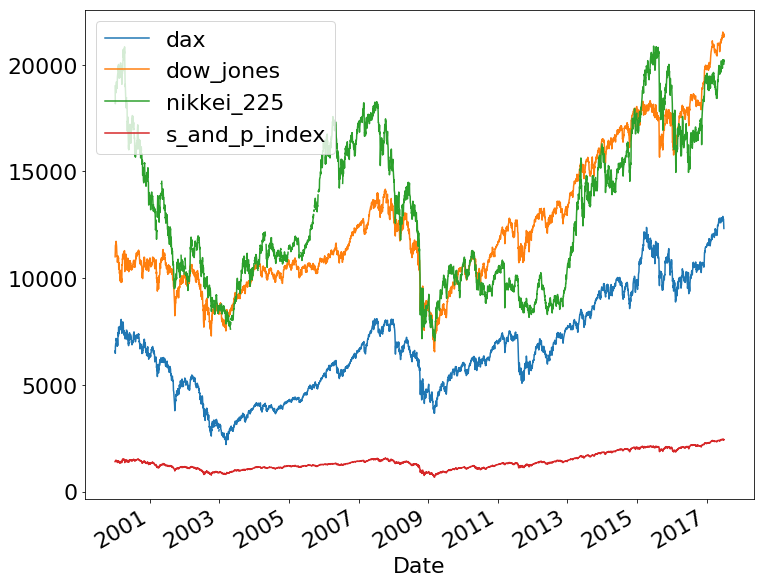

In [45]:
index_levels.plot(figsize=(12,10))

In [46]:
index_levels.corr()

,dax,dow_jones,nikkei_225,s_and_p_index
dax,1.000000,0.945942,0.748649,0.956878
dow_jones,0.945942,1.000000,0.698631,0.981534
nikkei_225,0.748649,0.698631,1.000000,0.787951
s_and_p_index,0.956878,0.981534,0.787951,1.000000


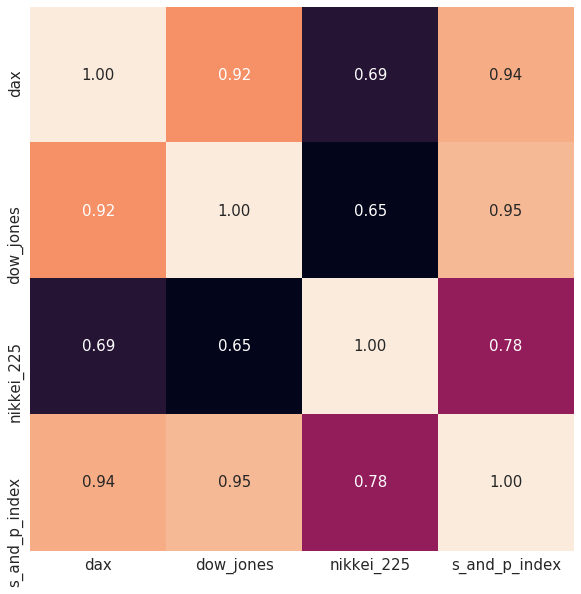

In [47]:
cpl = correlation_map(index_levels)

In [48]:
#index_returns.head()

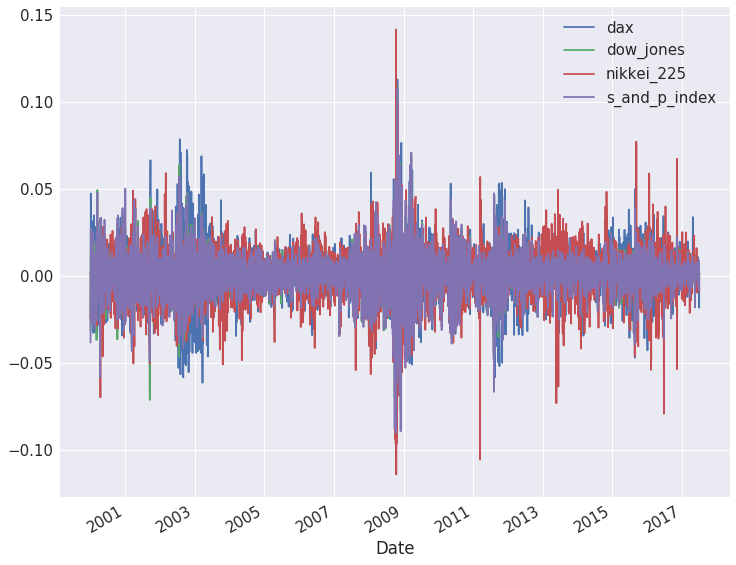

In [49]:
index_returns.plot(figsize=(12,10))

In [50]:
index_returns.corr()

,dax,dow_jones,nikkei_225,s_and_p_index
dax,1.000000,0.585063,0.265215,0.592122
dow_jones,0.585063,1.000000,0.132092,0.967818
nikkei_225,0.265215,0.132092,1.000000,0.132004
s_and_p_index,0.592122,0.967818,0.132004,1.000000


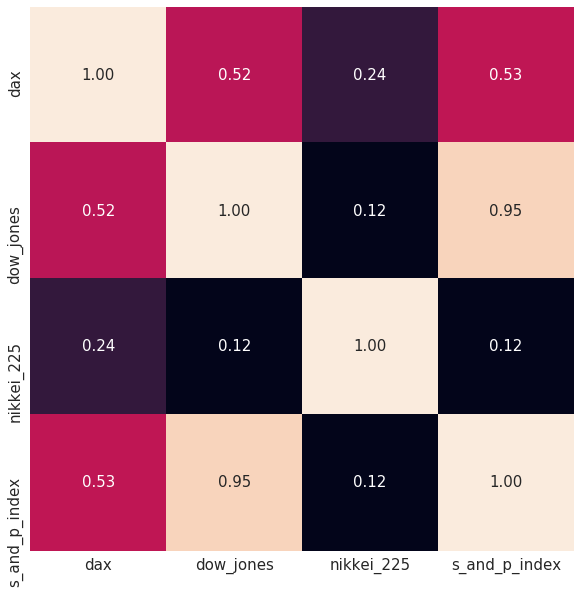

In [51]:
cpl = correlation_map(index_returns)

# Market regression

In [52]:

#start = auto_stocks_returns.index.min()
#end = auto_stocks_returns.index.max()
#index_returns_rest = df_restrict_dates(index_returns,start, end)

combined_returns = auto_stocks_returns.merge(index_returns, left_index=True, right_index=True)
mpl_dates = mpl.dates.date2num(combined_returns.index.to_pydatetime())

In [53]:
combined_returns.columns

Index(['BAYER MOTOREN WERK', 'BYD COMPANY LTD', 'DAIMLER AG',
       'FIAT CHRYSLER AUTO', 'FORD MTR CO', 'GEELY AUTOMOBILE H',
       'GENERAL MTRS CO COM', 'HONDA MOTOR CO', 'dax', 'dow_jones',
       'nikkei_225', 's_and_p_index'],
      dtype='object')

Coefficients: 
 [1.24002485]
Mean squared error: 0.00
Variance score: 0.59


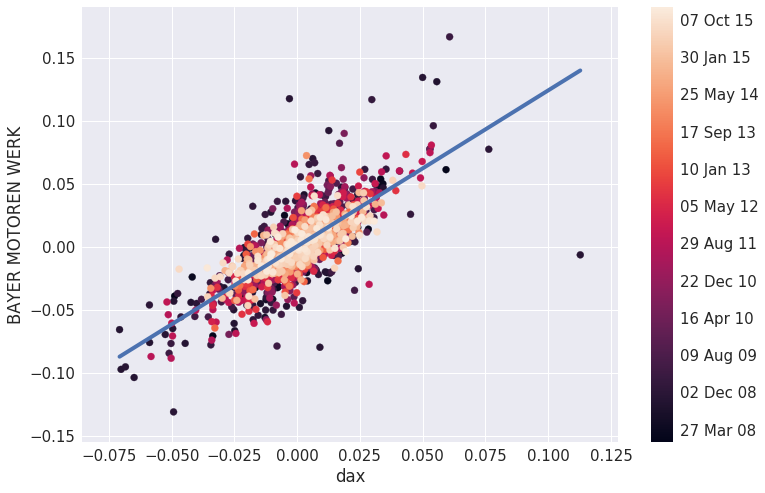

In [54]:
index_name = 'dax'
#index_name = 'dow_jones'
#index_name = 's_and_p_index'

#stock_name='FORD MTR CO'
stock_name = 'BAYER MOTOREN WERK'


# scikit linear regression
X = combined_returns[index_name].values.reshape(-1,1)
y = combined_returns[stock_name].values
lr = linear_model.LinearRegression()
lr.fit(X, y)

# The coefficients
print('Coefficients: \n', lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % np.mean((lr.predict(X) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lr.score(X,y))

alpha = lr.intercept_
beta= lr.coef_[0]


xgrid = np.linspace(X.min(), X.max(), 20)
y_pred = alpha + beta * xgrid


plt.figure(figsize=(12, 8))
plt.scatter(combined_returns[index_name], combined_returns[stock_name], c=mpl_dates, marker='o')
plt.grid(True)
plt.xlabel(index_name)
plt.ylabel(stock_name)
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))
plt.plot(xgrid, y_pred, lw=4)